### Data Preprocessing and Deep Learning Model Development

In [ ]:
# !unzip -q "/content/drive/MyDrive/Data Science/train.zip" -d "/content/drive/MyDrive/Data Science/Cargo Classification"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install openai nltk transformers langchain langchain_community tensorflow

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, models

df = pd.read_csv('/content/drive/MyDrive/DataScience/CargoClassification/train.csv')
df['filepath'] = df['image'].apply(lambda x: os.path.join('/content/drive/MyDrive/DataScience/CargoClassification/images', x))
df['label'] = pd.factorize(df['category'])[0]

df = df[df['image'] != '2823080.jpg']

def create_dataset(df, batch_size=32, img_size=(64, 64)):
    def load_image_and_label(filepath, label):
        image = tf.io.read_file(filepath)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, img_size) / 255.0
        return image, label

    dataset = tf.data.Dataset.from_tensor_slices((df['filepath'].values, df['label'].values))
    dataset = dataset.map(load_image_and_label).shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

dataset = create_dataset(df)

model = models.Sequential([
    layers.Input(shape=(64, 64, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(df['label'].unique()), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(dataset, epochs=25)

# model.save('/content/drive/MyDrive/DataScience/CargoClassification/Cargo_Classification_Model_25.keras')

Epoch 1/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 92s 414ms/step - accuracy: 0.3485 - loss: 1.5093
Epoch 2/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 122s 329ms/step - accuracy: 0.5127 - loss: 1.1846
Epoch 3/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 67s 327ms/step - accuracy: 0.6119 - loss: 0.9412
Epoch 4/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 80s 315ms/step - accuracy: 0.6502 - loss: 0.8601
Epoch 5/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 81s 306ms/step - accuracy: 0.7073 - loss: 0.7382
Epoch 6/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 84s 322ms/step - accuracy: 0.7378 - loss: 0.6750
Epoch 7/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 80s 315ms/step - accuracy: 0.7584 - loss: 0.5910
Epoch 8/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 67s 324ms/step - accuracy: 0.7897 - loss: 0.5329
Epoch 9/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 82s 323ms/step - accuracy: 0.8116 - loss: 0.4764
Epoch 10/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 86s 330ms/step - accuracy: 0.8348 - loss: 0.4219
Epoch 11/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 66s 318ms/step - accuracy: 0.8560 - loss: 0.3538
Epoch 12/25
196/19

###**Cargo Navigation [Computer Vision] & Notification System [Natural Language Processing-LLM]**

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step


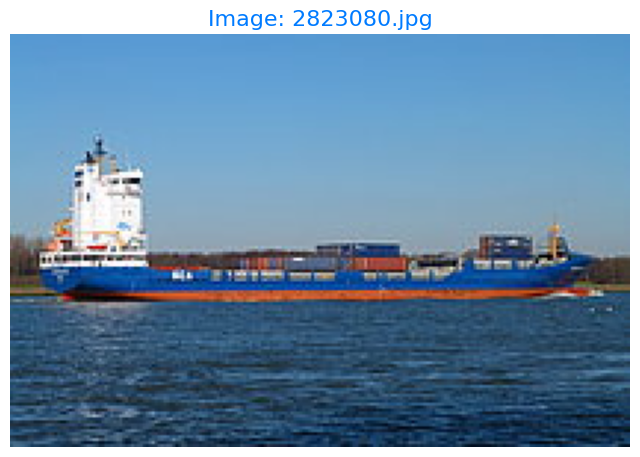

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from langchain.prompts import PromptTemplate
import re
import os
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import warnings
import nltk

warnings.filterwarnings("ignore")

nltk_data_path = nltk.data.find('tokenizers/punkt')
if not os.path.isfile(nltk_data_path):
    nltk.download('punkt')

model = tf.keras.models.load_model('/content/drive/MyDrive/DataScience/CargoClassification/Cargo_Classification_Model_50.keras')

df = pd.read_csv('/content/drive/MyDrive/DataScience/CargoClassification/train.csv')

label_encoder = LabelEncoder()
label_encoder.fit(df['category'])

message = "This is Ship ID: 2823080, Cargo Type: 1. We need entry to the Singapore's Tuas Port"

def preprocess_image(filepath):
    img = keras_image.load_img(filepath, target_size=(64, 64))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

def extract_info_from_message(message):
    tokens = word_tokenize(message)
    message_str = ' '.join(tokens)

    ship_id_match = re.search(r'Ship ID\s*:\s*(\d+)', message_str)
    cargo_type_match = re.search(r'Cargo Type\s*:\s*(\d+)', message_str)

    ship_id = ship_id_match.group(1).strip() if ship_id_match else None
    cargo_type = cargo_type_match.group(1).strip() if cargo_type_match else None

    if not ship_id or not cargo_type:
        raise ValueError(f"Ship ID or Cargo Type not found in message. Extracted Ship ID: {ship_id}, Cargo Type: {cargo_type}")

    return ship_id, cargo_type

def get_predicted_cargo_type(image_path):
    img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    cargo_type = label_encoder.inverse_transform([predicted_class])[0]
    return cargo_type, prediction

def generate_prompt(ship_id, cargo_type):
    prompt_template = PromptTemplate(
        input_variables=["ship_id", "cargo_type"],
        template="The Ship ID is {ship_id} and the Cargo Type is {cargo_type}. Requesting for Singapore's Tuas Port Entry"
    )
    prompt = prompt_template.format(ship_id=ship_id, cargo_type=cargo_type)
    return prompt

def get_llm_response(prompt):
    print(f"\nPrompt for LLM:\n{prompt}\n")
    return "Access Granted"

def main():
    ship_id, cargo_type = extract_info_from_message(message)

    image_filename = f"{ship_id}.jpg"
    image_path = os.path.join('/content/drive/MyDrive/DataScience/CargoClassification/images', image_filename)

    if not os.path.isfile(image_path):
        raise ValueError(f"Image file not found: {image_path}")

    predicted_cargo_type, prediction = get_predicted_cargo_type(image_path)

    display(HTML(f"""
    <div style="font-size: 18px; color: #333333; margin-bottom: 20px; background-color: #f8f9fa; padding: 15px; border-radius: 5px;">
        <h2 style="color: #007bff;">Ship Message</h2>
        <p><strong>Received Message:</strong> <span style="color: #007bff;">{message}</span></p>
    </div>
    """))

    display(HTML(f"""
    <div style="font-size: 18px; color: #333333; margin-bottom: 20px; background-color: #f8f9fa; padding: 15px; border-radius: 5px;">
        <h2 style="color: #007bff;">Cargo Type Extraction and Prediction</h2>
        <h3 style="color: #28a745;">Ship ID: 2823080 Found in Database</h3>
        <p><strong>Extracted Cargo Type from Message:</strong> <span style="color: #28a745;">{cargo_type}</span></p>
        <p><strong>Predicted Cargo Type:</strong> <span style="color: #28a745;">{predicted_cargo_type}</span></p>
    </div>
    """))

    img = keras_image.load_img(image_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"Image: {image_filename}", fontsize=16, color='#007bff')
    plt.axis('off')
    plt.show()

    prompt = generate_prompt(ship_id, cargo_type)
    response = "Access Granted" if str(cargo_type) == str(predicted_cargo_type) else "Your information needs to be assessed. Please contact +65 987654321"

    display(HTML(f"""
    <div style="font-size: 18px; color: #333333; margin-bottom: 20px; background-color: #f8f9fa; padding: 15px; border-radius: 5px;">
        <h2 style="color: #007bff;">LLM Response</h2>
        <p><strong>Cargo Type from Message:</strong> <span style="color: #28a745;">{cargo_type}</span></p>
        <p><strong>Predicted Cargo Type:</strong> <span style="color: #28a745;">{predicted_cargo_type}</span></p>
        <p><strong>LLM Response:</strong> <span style="color: {'#28a745' if response == 'Access Granted' else '#dc3545'};">{response}</span></p>
    </div>
    """))

main()